## 1. Creating the Main Functions

In [32]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score

In [33]:
data = pd.read_csv("AmesHousing.tsv", sep = '\t')

#houses.head(10)

In [3]:
def transform_features(df):
    np.random.seed(1)
    random_index = np.random.permutation(df.index)
    df = df.reindex(random_index)
    
    return df

In [35]:
def select_features(train_data_set):
    feat = train_data_set[['Gr Liv Area','SalePrice']]
    return feat

In [36]:
def train_and_test(dataset):
        
    len_dataset = dataset.shape[0]
    train_df = dataset[0:1460].copy()
    test_df = dataset[1461:len_dataset].copy()
       
    features = select_features(train_df)
    features = features.select_dtypes(include=['integer', 'float'])
    features = features.drop(columns = 'SalePrice')
    test_features_cols = select_features(test_df)
    test_features_cols = test_features_cols.drop(columns = 'SalePrice')
    
    model = LinearRegression()
    model.fit(features,train_df[['SalePrice']])

    prediction = model.predict(test_features_cols)
    
    test_rmse = np.sqrt(mean_squared_error(prediction, test_df[['SalePrice']]))
    
    return test_rmse
    

In [6]:
transformed_data = transform_features(data)
train_and_test(transformed_data)

55928.5197683182

## 2. Data Cleaning

* We will test the cleaning process first on standalone cells, and later we will add them to the transform_features function

In [7]:
data.shape[1]

82

In [8]:
#1. Drop any columns with more than 5% of values missing
missing_count = data.isnull().sum()
missing_cols = missing_count[missing_count>data.shape[0]*0.05].index
data.drop(columns = missing_cols, inplace = True)

data.shape[1]

71

In [9]:
#2. Drop any text column with more than 1 missing value
text_data = data.select_dtypes(include=['object'])
text_data_missing = text_data.isnull().sum()
missing_cols = text_data_missing[text_data_missing > 0].index
data.drop(columns = missing_cols, inplace = True)
data.shape[1]

64

In [10]:
#3. Fill in numeric colums with less than 5% missing values ith the most common (mode) value of that column
numeric_data = data.select_dtypes(include = ['int64','float64'])
numeric_data_missing = numeric_data.isnull().sum()
missing_cols = numeric_data_missing[(numeric_data_missing > 0) & (numeric_data_missing < data.shape[0]*0.05)]
mode = data[missing_cols.index].mode() #returns a dataframe with the mode for each value
mode = mode.to_dict(orient = 'records')[0] #"records" argument [{column -> value}, … , {column -> value}]
data.fillna(value = mode, inplace = True)

In [11]:
#Checking if all values are null
data.isnull().sum().value_counts()

0    64
dtype: int64

In [12]:
#4. Add more columns
data['Years Before Sale'] = data['Yr Sold'] - data['Year Built']
data['Years Since Remod'] = data['Yr Sold'] - data['Year Remod/Add']

In [13]:
negative_yrs_bef_sale = data['Years Before Sale'][data['Years Before Sale'] <0].index

In [14]:
negative_yrs_since_remod = data['Years Since Remod'][data['Years Since Remod'] <0].index

In [15]:
data.drop(index = negative_yrs_bef_sale.union(negative_yrs_since_remod),inplace = True) #dropping the ones that result in negative values

In [16]:
data.drop(columns = ['Year Built','Year Remod/Add'],inplace = True) #we don't need these anymored

In [17]:
#5. Dropping unnecessary columns
## Drop columns that aren't useful for ML
data.drop(columns = ["PID", "Order"], inplace = True)

## Drop columns that leak info about the final sale
data.drop(columns = ["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"], inplace = True)

## 3. Updating the transform_features function with the data cleaning

In [37]:
def transform_features(data):
  
    data = data.sample(frac = 1, random_state = 1)
    
    #data_cleaning:
    #1. Drop any columns with more than 5% of values missing
    missing_count = data.isnull().sum()
    missing_cols = missing_count[missing_count>data.shape[0]*0.05].index
    data.drop(columns = missing_cols, inplace = True)
    
    #2. Drop any text column with more than 1 missing value
    text_data = data.select_dtypes(include=['object'])
    text_data_missing = text_data.isnull().sum()
    missing_cols = text_data_missing[text_data_missing > 0].index
    data.drop(columns = missing_cols, inplace = True)
    
    #3. Fill in numeric colums with less than 5% missing values ith the most common (mode) value of that column
    numeric_data = data.select_dtypes(include = ['int64','float64'])
    numeric_data_missing = numeric_data.isnull().sum()
    #missing_cols = numeric_data_missing[(numeric_data_missing > 0) & (numeric_data_missing < data.shape[0]*0.05)]
    missing_cols = numeric_data_missing[(numeric_data_missing > 0)]
    mode = data[missing_cols.index].mode() #retunrs a dataframe with the mode for each value
    mode = mode.to_dict(orient = 'records')[0] #"records" argument [{column -> value}, … , {column -> value}]
    data.fillna(value = mode, inplace = True)
    
    #4. Add more columns
    data['Years Before Sale'] = data['Yr Sold'] - data['Year Built']
    data['Years Since Remod'] = data['Yr Sold'] - data['Year Remod/Add']
    
    negative_yrs_bef_sale = data['Years Before Sale'][data['Years Before Sale'] <0].index
    negative_yrs_since_remod = data['Years Since Remod'][data['Years Since Remod'] <0].index
    
    data.drop(index = negative_yrs_bef_sale.union(negative_yrs_since_remod),inplace = True) #dropping the ones that result in negative values
    data.drop(columns = ['Year Built','Year Remod/Add'],inplace = True) #we don't need these anymored
    
    #5. Droping unnecessary columns
    ## Drop columns that aren't useful for ML
    data.drop(columns = ["PID", "Order"], inplace = True)

    ## Drop columns that leak info about the final sale
    data.drop(columns = ["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"], inplace = True)
        
    return data

In [38]:
data = pd.read_csv("AmesHousing.tsv", sep = '\t')
transformed_data = transform_features(data)
train_and_test(transformed_data)

54979.96874691935

In [20]:
54979.96874691935

54979.96874691935

## 4. Feature Selection

* Numerical Features
* We will first analyse the features on standalone cells, and then incorporate the transformation and selections into the select features function

In [21]:
#Calculating the correlation of the numeric features with the SalePrice column
transformed_data_num_train = transformed_data.copy().select_dtypes(include = ['int64','float64'])
saleprice_corr = transformed_data_num_train.corr()['SalePrice'].abs().sort_values(ascending = False)
saleprice_corr

SalePrice            1.000000
Overall Qual         0.801206
Gr Liv Area          0.717596
Garage Cars          0.648361
Total Bsmt SF        0.644012
Garage Area          0.641425
1st Flr SF           0.635185
Years Before Sale    0.558979
Full Bath            0.546118
Years Since Remod    0.534985
Mas Vnr Area         0.506983
TotRms AbvGrd        0.498574
Fireplaces           0.474831
BsmtFin SF 1         0.439284
Wood Deck SF         0.328183
Open Porch SF        0.316262
Half Bath            0.284871
Bsmt Full Bath       0.276258
2nd Flr SF           0.269601
Lot Area             0.267520
Bsmt Unf SF          0.182751
Bedroom AbvGr        0.143916
Enclosed Porch       0.128685
Kitchen AbvGr        0.119760
Screen Porch         0.112280
Overall Cond         0.101540
MS SubClass          0.085128
Pool Area            0.068438
Low Qual Fin SF      0.037629
Bsmt Half Bath       0.035875
3Ssn Porch           0.032268
Misc Val             0.019273
BsmtFin SF 2         0.006127
Name: Sale

In [22]:
#Dropping columns with a corr bellow than 0.3
weak_correlation = saleprice_corr[saleprice_corr < 0.3].index
transformed_data.drop(columns = weak_correlation, inplace = True)

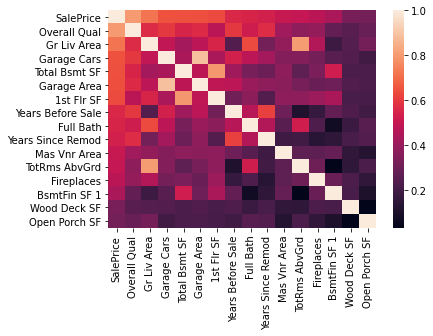

In [23]:
#Looking for other variables that have a strong correlation between them and therefore should be dropped
strong_saleprice_corr = saleprice_corr[saleprice_corr > 0.3].index
sns.heatmap(transformed_data_num_train[strong_saleprice_corr].corr().abs())

In [24]:
#Dropping columns with a strong correlation with another column
transformed_data.drop(columns = ['Garage Cars','TotRms AbvGrd','1st Flr SF'], inplace = True)

* Analyzing categorical features

In [25]:
#Dropping category columns with too many distinct values

## Create a list of column names from documentation that are *meant* to be categorical
nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]

#Checking which of those columns are still in our transformed dataset
transform_cat_cols = []
for col in nominal_features:
    if col in transformed_data.columns:
        transform_cat_cols.append(col)

#Couting the unique values in those columns and dropping columns with too many (>10) unique values
uniqueness_counts  = transformed_data[transform_cat_cols].apply(lambda col: len(col.value_counts()), axis =0)
transformed_data.drop(columns = uniqueness_counts[uniqueness_counts > 10].index, inplace = True)

In [26]:
# Transforming remaing text columns into category columns and then dummy coding them
text_cols = transformed_data.select_dtypes(include = 'object').columns

for col in text_cols:
    transformed_data[col] = transformed_data[col].astype('category')

dummies = pd.get_dummies(transformed_data.select_dtypes(include = 'category'))

transformed_data = pd.concat([transformed_data,dummies], axis = 1)


transformed_data.drop(columns = text_cols, inplace = True)



## 5. Updating Select Features with the modifications done above

In [27]:
def select_features(train_data_set,corr_threshold = 0.3,n_categories_threshold = 10):
    
    ##NUMERIC COLUMNS
    #Calculating the correlation of the numeric features with the SalePrice column
    train_data_set_num = train_data_set.copy().select_dtypes(include = ['int64','float64'])
    saleprice_corr = train_data_set_num.corr()['SalePrice'].abs().sort_values(ascending = False)
    
    #Dropping columns with a corr bellow than 0.3
    weak_correlation = saleprice_corr[saleprice_corr < corr_threshold].index
    train_data_set.drop(columns = weak_correlation, inplace = True)
    
    #Dropping columns with a strong correlation with another column
    train_data_set.drop(columns = ['Garage Cars','TotRms AbvGrd','1st Flr SF'], inplace = True)
    
    
    ##TEXT COLUMNS
    #Dropping category columns with too many distinct values
    ## Create a list of column names from documentation that are *meant* to be categorical
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]

    #Checking which of those columns are still in our transformed dataset
    transform_cat_cols = []
    for col in nominal_features:
        if col in train_data_set.columns:
            transform_cat_cols.append(col)

    #Couting the unique values in those columns and dropping columns with too many (>10) unique values
    uniqueness_counts  = train_data_set[transform_cat_cols].apply(lambda col: len(col.value_counts()), axis =0)
    train_data_set.drop(columns = uniqueness_counts[uniqueness_counts > n_categories_threshold].index, inplace = True)
    
    #Transforming remaing text columns into category columns and then dummy coding them
    text_cols = train_data_set.select_dtypes(include = 'object').columns

    for col in text_cols:
        train_data_set[col] = train_data_set[col].astype('category')

    dummies = pd.get_dummies(train_data_set.select_dtypes(include = 'category'))

    train_data_set = pd.concat([train_data_set,dummies], axis = 1)

    features = train_data_set.drop(columns = text_cols)

    return features

* Updating train and test to take into the considerantion the changes done in select features

In [28]:
def train_and_test(dataset):
    
    dataset = select_features(dataset)
    
    len_dataset = dataset.shape[0]
    train_df = dataset[:1460].copy()
    test_df = dataset[1460:].copy()
       
    train_features = train_df.drop(columns = "SalePrice")
    test_features = test_df.drop(columns = "SalePrice")
    
    model = LinearRegression()
    model.fit(train_features,train_df[['SalePrice']])

    prediction = model.predict(test_features)
    
    test_rmse = np.sqrt(mean_squared_error(prediction, test_df[['SalePrice']]))
    
    return round(test_rmse,2)

In [29]:
data = pd.read_csv("AmesHousing.tsv", sep = '\t')
transformed_data = transform_features(data)
train_and_test(transformed_data)

27353.95

## 6. Updating the train_and_test to use k-fold cross validation

In [30]:
def train_and_test(dataset):
    
    dataset = select_features(dataset)
    
    kf = KFold() #it is using the defalut 5 folds and no shuffle (the dataset has already been shuffled once)
    
    features = dataset.drop(columns = "SalePrice")
    target = dataset[['SalePrice']]
    
    model = LinearRegression()
    
    mses = cross_val_score(model, features, target, scoring = 'neg_mean_squared_error')
    
    rmses = np.sqrt(np.absolute(mses))
    
    avg_rmse = np.mean(rmses)
    return avg_rmse

In [31]:
data = pd.read_csv("AmesHousing.tsv", sep = '\t')
transformed_data = transform_features(data)
train_and_test(transformed_data)

29022.357586053702